# INTRO

In [25]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pandas --upgrade
!pip install scikit-plot


from collections import defaultdict


Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

rimuovo la data in quanto genera troppi campi binari non utili alla classificazione, troppa dimensionalità nel dataset

Rimuovo il campo "Date" dal dataset originale, in quanto poco utile alla classificazione in corso. 

In [27]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/rebalanced/nearmiss.csv"
df = pd.read_csv(dataset_path)





df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [29]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


# GAUSSIAN BAYES

In [0]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score



attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [31]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

predico il naive bayes gaussiano (utile per dataset con valori continui) sul training set senza modificare o rimuovere alcun campo

In [0]:
y_pred = clf.predict(X_test)

In [33]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8633333333333333
F1-score [0.86006826 0.86644951]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       300
           1       0.85      0.89      0.87       300

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [34]:
df[numeric_columns].head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


considero solo i valori numerici nel dataset, rimuovendo le variabili binarie (non ho ancora rimosso weekend e working hour) predico nuovamente con il gaussiano

In [0]:
X_train_num, X_test_num, y_train, y_test = train_test_split(
    df[[c for c in numeric_columns if c != class_name]], df[class_name], 
       test_size=0.3, random_state=100, stratify=df[class_name])

In [36]:
clf = GaussianNB()
clf.fit(X_train_num, y_train)
y_pred = clf.predict(X_test_num)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8633333333333333
F1-score [0.86006826 0.86644951]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       300
           1       0.85      0.89      0.87       300

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



statistiche migliorate leggermente

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8285 (+/- 0.36)
F1-score: 0.8132 (+/- 0.40)


effettuo una cross validation per validare il classificatore

600
600


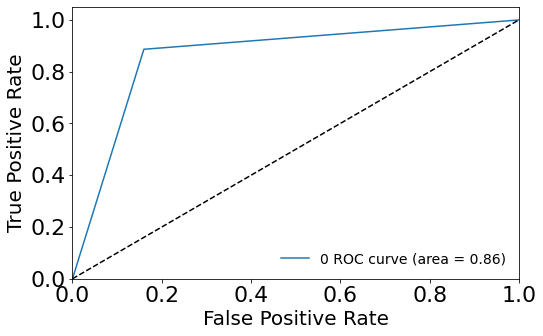

In [38]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)

print (by_test.size)
print (by_pred.size)

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

stampo la roc curve del classificatore (interpreta)

lift chart gaussian NB

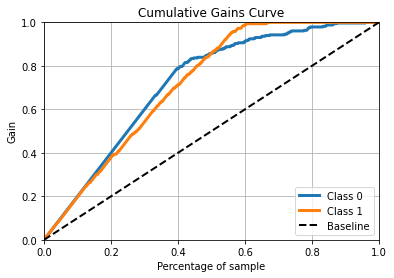

In [39]:
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

nb = GaussianNB()

nb.fit(X_train, y_train)

predicted_probas = nb.predict_proba(X_test)

# The magic happens here

import matplotlib.pyplot as plt

import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()

stampo il lift chart del classificatore gaussiano (da interpretare)

#GAUSSIANO MA RIMUOVO LE VARIABILI NUMERICHE INTERE

In [41]:
df = pd.read_csv(dataset_path)

df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,9.469954,9.966601,6.374135,6.632908,9.512220,0
1,11.171032,8.952904,6.327000,8.070624,9.182671,0
2,12.028968,7.593496,5.949919,5.552938,8.142044,0
3,11.171032,8.929466,6.327000,7.998497,9.159434,0
4,11.466872,9.662743,7.050186,8.973232,10.004444,0


In [42]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8633333333333333
F1-score [0.86006826 0.86644951]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       300
           1       0.85      0.89      0.87       300

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8285 (+/- 0.36)
F1-score: 0.8132 (+/- 0.40)


600
600


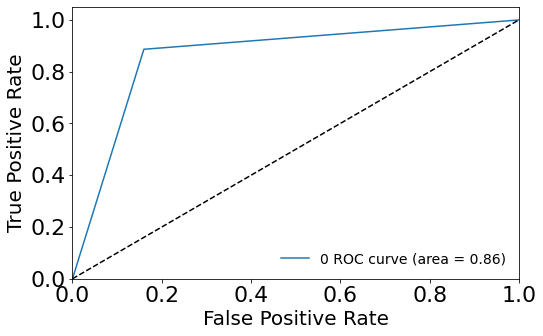

In [44]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)

print (by_test.size)
print (by_pred.size)

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

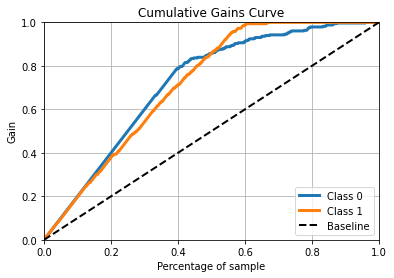

In [45]:
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

nb = GaussianNB()

nb.fit(X_train, y_train)

predicted_probas = nb.predict_proba(X_test)

# The magic happens here

import matplotlib.pyplot as plt

import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()